In [84]:
import tensorflow as tf
from tensorflow.keras import layers
from tensorflow import keras
from tensorflow.keras.optimizers import SGD
import numpy as np
import pathlib
import matplotlib.pyplot as plt
from os.path import dirname, join as pjoin
import scipy.io as sio
import h5py
import hdf5storage
import random
from tensorflow.keras.models import model_from_json
from tensorflow.keras.models import load_model
from PIL import Image
from matplotlib.image import imread
import os
from tensorflow.keras import applications
from sklearn.datasets import load_svmlight_file
import nltk
from nltk.tokenize import sent_tokenize, word_tokenize
from nltk.tokenize import RegexpTokenizer
from keras.preprocessing import sequence
from keras import Sequential
import pandas as pd
import statsmodels.api as sm
from statsmodels.tsa.arima_model import ARIMA
from keras.layers import Embedding, LSTM, Dense, Dropout, Input, Bidirectional, Conv1D, Flatten, GRU, AveragePooling1D
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import MinMaxScaler

In [2]:
DATASET_URL = 'https://www.kaggle.com/robervalt/sunspots/download'
DATASET_PATH = './Sunspots.csv'

In [3]:
sunspots_ds = pd.read_csv(DATASET_PATH, parse_dates=['Date'])
sunspots_ds

,Unnamed: 0,Date,Monthly Mean Total Sunspot Number
0,0,1749-01-31,96.7
1,1,1749-02-28,104.3
2,2,1749-03-31,116.7
3,3,1749-04-30,92.8
4,4,1749-05-31,141.7
...,...,...,...
3247,3247,2019-08-31,0.5
3248,3248,2019-09-30,1.1
3249,3249,2019-10-31,0.4
3250,3250,2019-11-30,0.5


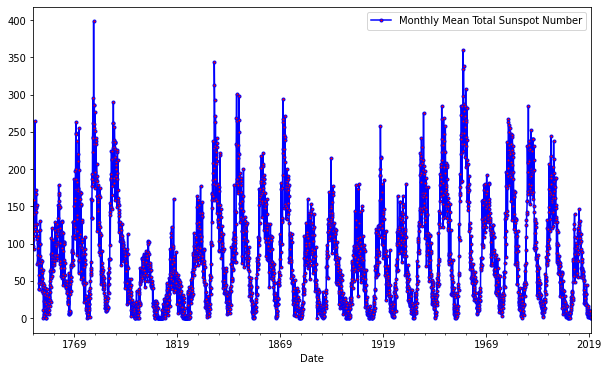

In [4]:
sunspots_ds.set_index('Date', inplace=True)
sunspots_prepared = sunspots_ds.iloc[:,1:]
sunspots_prepared.plot(figsize=(10,6), marker = '.', color='blue', markerfacecolor='red', legend=True)

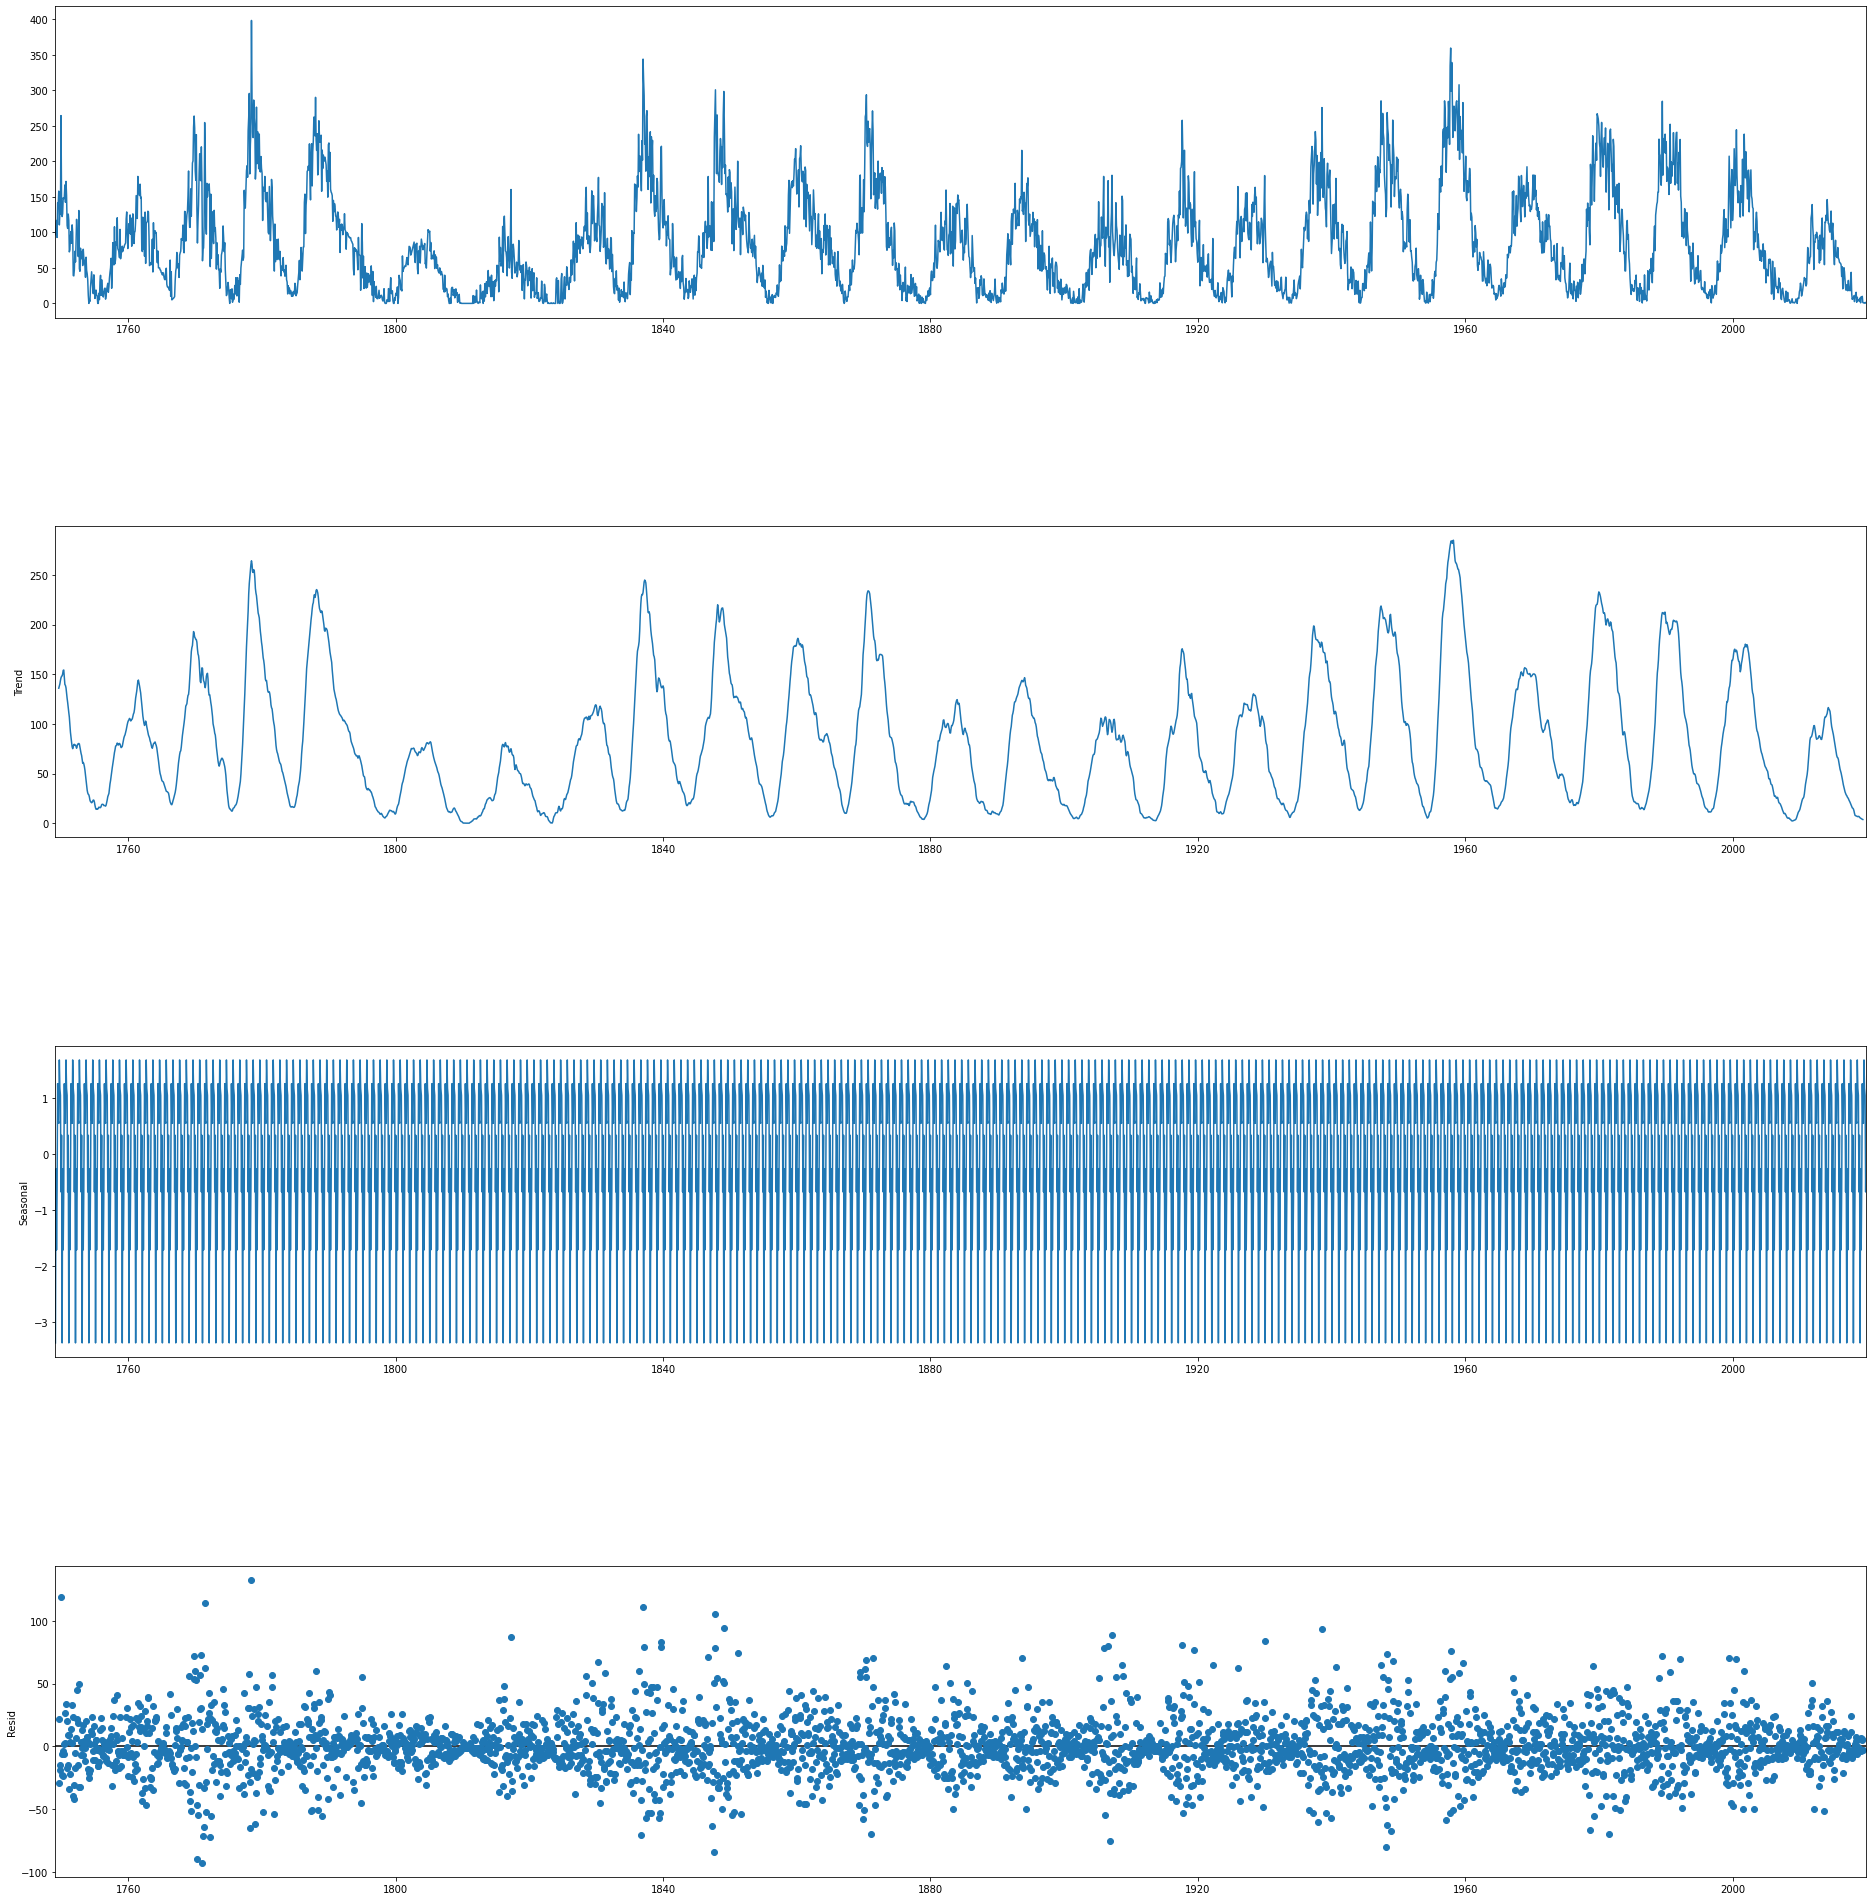

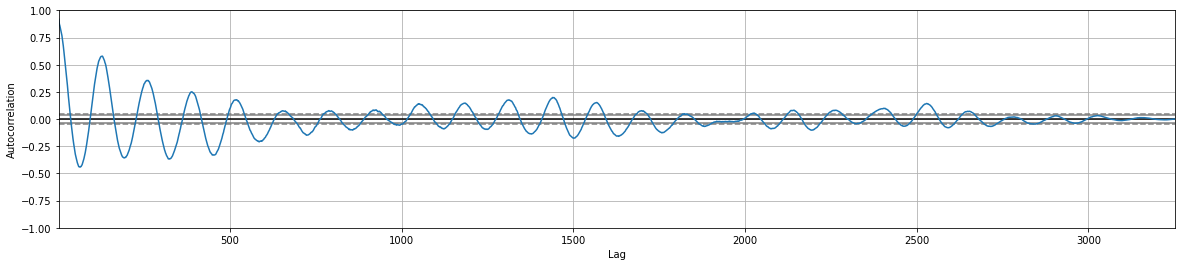

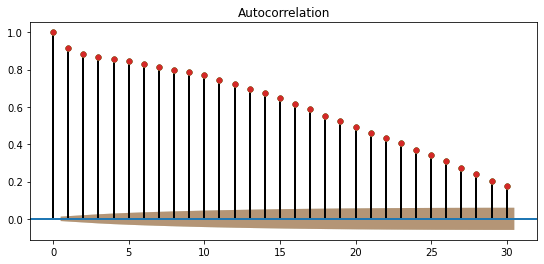

<Figure size 1440x288 with 0 Axes>

In [25]:
decomposition = sm.tsa.seasonal_decompose(sunspots_prepared, model='additive')
fig = decomposition.plot()
fig.set_size_inches(30, 30)
plt.show()

fig = plt.figure()
fig.set_size_inches((20, 4))
fig.add_subplot(pd.plotting.autocorrelation_plot(sunspots_prepared))
plt.show()

fig = plt.figure(figsize=(20, 4))
layout = (1, 2)
sm.tsa.graphics.plot_acf(sunspots_prepared, lags=30, ax=acf_ax, alpha=0.5)

In [71]:
# SPLIT ON SETS
TRAIN_PERCENTS = 0.8
VALIDATION_PERCENTS = 0.1
TEST_PERCENTS = 0.1
samples_count = len(sunspots_prepared)

print('Total samples count = ', samples_count)
train_sds_size = int(samples_count * TRAIN_PERCENTS)
validation_sds_size = int(samples_count * VALIDATION_PERCENTS)
test_sds_size = samples_count - train_sds_size - validation_sds_size

train_sds = sunspots_prepared.values[:train_sds_size]
validation_sds = sunspots_prepared.values[train_sds_size:train_sds_size+validation_sds_size]
test_sds = sunspots_prepared.values[train_sds_size+validation_sds_size:]
print('Train set size = ', len(train_sds))
print('Validation set size = ', len(validation_sds))
print('Test set size = ', len(test_sds))

Total samples count =  3252
Train set size =  2601
Validation set size =  325
Test set size =  326


In [76]:
sequence_history = [x for x in train_sds]
predictions = []

for sample_index in range(len(validation_sds)):
    arima_model = ARIMA(sequence_history, order=(10,1,0))
    arima_model = arima_model.fit(disp=True)
    prediction = arima_model.forecast()[0]
    predictions.append(prediction)
    print(sample_index)
    real_value = validation_sds[sample_index]
    sequence_history.append(real_value)

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
200
201
202
203
204
205
206
207
208
209
210
211
212
213
214
215
216
217
218
219
220
221
222
223
224
225
226
227
228
229
230
231
232
233
234
235
236
237
238
239
240
241
242
243
244
245
246
247
248
249
250
251
252
253
254
255
256
257
258
259
260
261
262
263
264
265
266
267
268
269
270
271
272
273
274
275
276
27

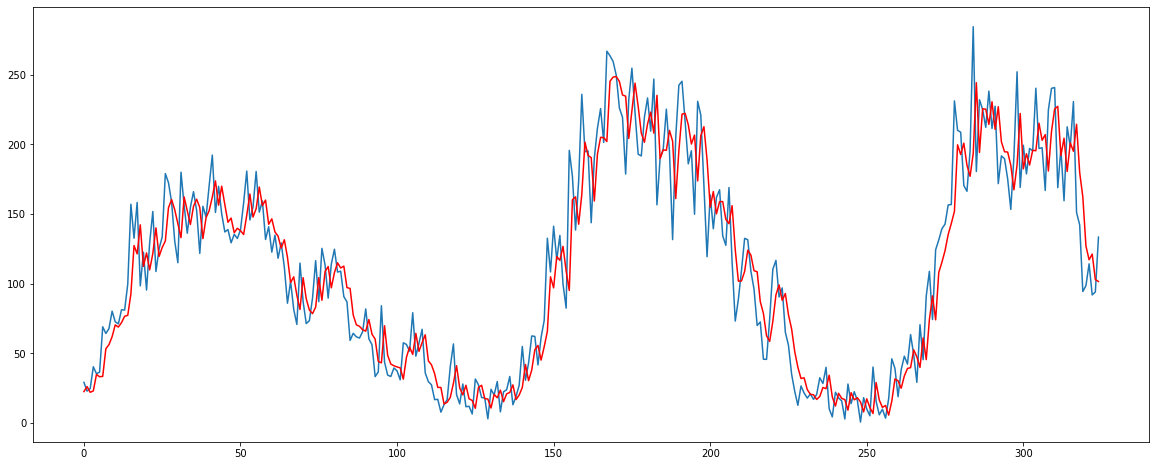

In [82]:
fig = plt.figure()
fig.set_size_inches((20, 8))
plt.plot(validation_sds)
plt.plot(predictions, color='red')
plt.show()

In [88]:
# PREPARE DATA FOR RNN
sunspots_values = sunspots_prepared.values
scaler = MinMaxScaler(feature_range=(0, 1))
sunspots_values = scaler.fit_transform(sunspots_values)

timeseries_size = 15
x = [] 
y = []
for i in range(sunspots_values.shape[0] - timeseries_size):
    x.append(sunspots_values[i:i + timeseries_size, :])
    y.append(sunspots_values[i + timeseries_size, :])
x = np.array(x)
y = np.array(y)

print(x.shape)
print(y.shape)

(3237, 15, 1)
(3237, 1)


In [104]:
EPOCHS = 15
BATCH_SIZE = 64

model = keras.Sequential([
    layers.Input(shape=(x.shape[1], x.shape[2])),
    layers.AveragePooling1D(),
    layers.Bidirectional(layers.LSTM(100, return_sequences=True)),
    layers.Bidirectional(layers.LSTM(128)),
    layers.Dense(1, activation='sigmoid', name='output')
])

model.summary()    
# Compile model
model.compile(
    loss='mean_squared_error', 
    optimizer='adam', 
    metrics=['accuracy']
)

Model: "sequential_6"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
average_pooling1d_8 (Average (None, 7, 1)              0         
_________________________________________________________________
bidirectional_12 (Bidirectio (None, 7, 200)            81600     
_________________________________________________________________
bidirectional_13 (Bidirectio (None, 256)               336896    
_________________________________________________________________
output (Dense)               (None, 1)                 257       
Total params: 418,753
Trainable params: 418,753
Non-trainable params: 0
_________________________________________________________________


In [105]:
history = model.fit(
    x,
    y,
    epochs=EPOCHS,
    batch_size=BATCH_SIZE,
)

Train on 3237 samples
Epoch 1/15
3237/3237 [==============================] - 4s 1ms/sample - loss: 0.0392 - accuracy: 0.0207
Epoch 2/15
3237/3237 [==============================] - 1s 233us/sample - loss: 0.0084 - accuracy: 0.0207
Epoch 3/15
3237/3237 [==============================] - 1s 235us/sample - loss: 0.0068 - accuracy: 0.0210
Epoch 4/15
3237/3237 [==============================] - 1s 413us/sample - loss: 0.0060 - accuracy: 0.0210
Epoch 5/15
3237/3237 [==============================] - 2s 498us/sample - loss: 0.0058 - accuracy: 0.0210
Epoch 6/15
3237/3237 [==============================] - 2s 502us/sample - loss: 0.0059 - accuracy: 0.0210
Epoch 7/15
3237/3237 [==============================] - 2s 501us/sample - loss: 0.0056 - accuracy: 0.0210
Epoch 8/15
3237/3237 [==============================] - 2s 492us/sample - loss: 0.0061 - accuracy: 0.0210
Epoch 9/15
3237/3237 [==============================] - 2s 480us/sample - loss: 0.0059 - accuracy: 0.0210
Epoch 10/15
3237/3237 [===

In [107]:
def plot_history(history):
    # Plot training & validation accuracy values
    plt.plot(history.history['accuracy'])
#     plt.plot(history.history['val_accuracy'])
    plt.title('Model accuracy')
    plt.ylabel('Accuracy')
    plt.xlabel('Epoch')
    plt.legend(['Train'], loc='upper left')
    plt.show()

    # Plot training & validation loss values
    plt.plot(history.history['loss'])
#     plt.plot(history.history['val_loss'])
    plt.title('Model loss')
    plt.ylabel('Loss')
    plt.xlabel('Epoch')
    plt.legend(['Train'], loc='upper left')
    plt.show()

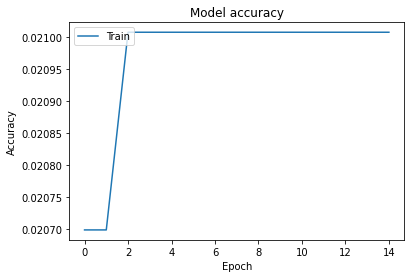

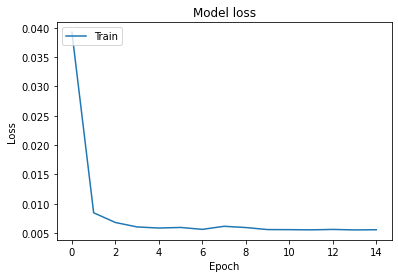

In [109]:
plot_history(history)

In [113]:
test_period_values = x[:1000]
prediction = model.predict(test_period_values)
prediction

array([[0.40800145],
       [0.39100337],
       [0.40238404],
       [0.39139837],
       [0.40852866],
       [0.39713863],
       [0.41370523],
       [0.4147652 ],
       [0.37703398],
       [0.34126592],
       [0.32903022],
       [0.33086804],
       [0.28574228],
       [0.24858269],
       [0.23620231],
       [0.235288  ],
       [0.2244208 ],
       [0.2332062 ],
       [0.24278061],
       [0.19982234],
       [0.16861364],
       [0.15315492],
       [0.15562724],
       [0.15263757],
       [0.1652019 ],
       [0.21084541],
       [0.22736637],
       [0.24005596],
       [0.22841768],
       [0.26320785],
       [0.24262036],
       [0.20159984],
       [0.21390073],
       [0.19251679],
       [0.1853486 ],
       [0.17860676],
       [0.1674909 ],
       [0.16511327],
       [0.16703568],
       [0.16073948],
       [0.15786003],
       [0.13834631],
       [0.14339833],
       [0.14470428],
       [0.1295017 ],
       [0.11518092],
       [0.08870382],
       [0.062

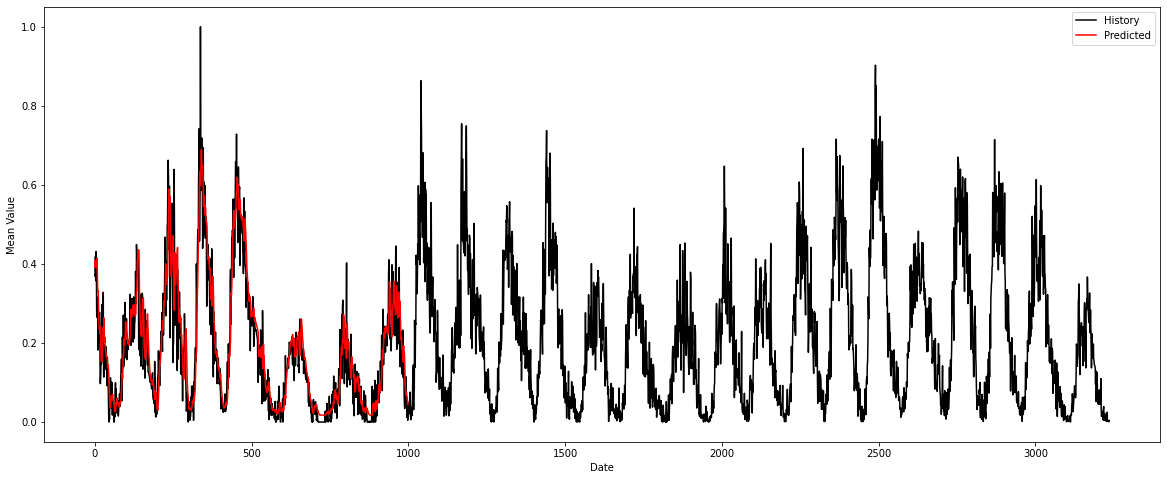

In [123]:
plt.subplots(figsize=(20, 8))
plt.ylabel('Mean Value')
plt.xlabel('Date')
plt.plot(np.arange(0, len(x)), y, color='black', label="History")
plt.plot(np.arange(0, len(test_period_values)), prediction, 'red', label="Predicted")
plt.legend()
plt.show()